<a href="https://colab.research.google.com/github/deondmello16/PyTorch-Journey/blob/main/PyTorch_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Transfer Learning

%%html
<!DOCTYPE html>
<html>

<head>
  <style>
    table {
      font-family: Arial, sans-serif;
      border-collapse: collapse;
      width: 100%;
    }

    th, td {
      width : 300px;
      border: 1px solid #dddddd;
      text-align: left;
      padding: 8px;
    }

    th {
      background-color: #f2f2f2;
    }
  </style>
</head>

<body>

  <h2>Pretrained Models Locations</h2>

  <table>
    <tr>
      <th>Location</th>
      <th>What's there?</th>
      <th>Link(s)</th>
    </tr>
    <tr>
      <td>PyTorch domain libraries</td>
      <td>Each of the PyTorch domain libraries (torchvision, torchtext) come with pretrained models of some form. The models there work right within PyTorch.</td>
      <td><code>torchvision.models</code>, <code>torchtext.models</code>, <code>torchaudio.models</code>, <code>torchrec.models</code></td>
    </tr>
    <tr>
      <td>HuggingFace Hub</td>
      <td>A series of pretrained models on many different domains (vision, text, audio and more) from organizations around the world. There's plenty of different datasets too.</td>
      <td><a href="https://huggingface.co/models" target="_blank">HuggingFace Models</a>, <a href="https://huggingface.co/datasets" target="_blank">HuggingFace Datasets</a></td>
    </tr>
    <tr>
      <td><code>timm</code> (PyTorch Image Models) library</td>
      <td>Almost all of the latest and greatest computer vision models in PyTorch code as well as plenty of other helpful computer vision features.</td>
      <td><a href="https://github.com/rwightman/pytorch-image-models" target="_blank">timm GitHub</a></td>
    </tr>
    <tr>
      <td>Paperswithcode</td>
      <td>A collection of the latest state-of-the-art machine learning papers with code implementations attached. You can also find benchmarks here of model performance on different tasks.</td>
      <td><a href="https://paperswithcode.com/" target="_blank">Paperswithcode</a></td>
    </tr>
  </table>

</body>

</html>


In [6]:
try :
  import torch
  import torchvision

  assert int(torch.__version__.split('.')[0]) >= 2, "torch version should be 2.0+"
  assert int(torchvision.__version__.split('.')[1]) >= 16, "torchvision version should be 16+"

except :
  print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
  !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu121
  import torch
  import torchvision
  print(f"torch version: {torch.__version__}")
  print(f"torchvision version: {torchvision.__version__}")

In [7]:
import matplotlib.pyplot as plt
import torch
import torchvision


from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader

try:
  import torchinfo
except:
  !pip install -q torchinfo
  import torchinfo


In [8]:
device = "cude" if torch.cuda.is_available() else "cpu"
device

'cpu'

## Getting the dataset

In [12]:
import os
import zipfile

from pathlib import Path

import requests


data_path = Path("data/")
image_path = data_path/"pizza_steak_sushi"

if(image_path.is_dir()):
  print(f"Image Dir {image_path} already exits")

else:
  print("Data Dir doesn't exist")
  print("Making new Dir...")

  image_path.mkdir(parents=True,exist_ok=True)

  with open(data_path/"pizza_steak_sushi.zip",'wb') as zp:

    req = requests.get("https://github.com/deondmello16/PyTorch-Journey/raw/main/data/pizza_steak_sushi.zip")
    print("File being downloaded")
    zp.write(req.content)

  with zipfile.ZipFile(data_path/'pizza_steak_sushi.zip','r') as zp:
    print(f"Extracting all the files into {image_path}")
    zp.extractall(image_path)

os.remove(data_path/"pizza_steak_sushi.zip")

Data Dir doesn't exist
Making new Dir...
File being downloaded
Extracting all the files into data/pizza_steak_sushi


## Creating Datasets and DataLoaders

In [20]:
preprocessing = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=32),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]),
    transforms.ToTensor()
])

In [21]:
preprocessing

Compose(
    Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
    TrivialAugmentWide(num_magnitude_bins=32, interpolation=InterpolationMode.NEAREST, fill=None)
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ToTensor()
)

In [22]:
from torchvision.datasets import ImageFolder

train_dir = image_path/"train"
test_dir = image_path/"test"


train_data = ImageFolder(
    root = train_dir,
    transform=preprocessing,
    # target_transform = ToTensor(),
)
test_data = ImageFolder(
    root = test_dir,
    transform=preprocessing,
    # target_transform = ToTensor(),
)

train_data,test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                TrivialAugmentWide(num_magnitude_bins=32, interpolation=InterpolationMode.NEAREST, fill=None)
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                TrivialAugmentWide(num_magnitude_bins=32, interpolation=InterpolationMode.NEAREST, fill=None)
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                ToTensor()
            ))

In [23]:
# time for dataloaders

train_dataloader = DataLoader(dataset=train_data,
                              batch_size = 32,
                              num_workers=os.cpu_count(),
                              shuffle = True)
test_dataloader = DataLoader(dataset=test_data,
                              batch_size = 32,
                              num_workers=os.cpu_count(),
                              # shuffle = True
                              )

train_dataloader,test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7e2c967cbdf0>,
 <torch.utils.data.dataloader.DataLoader at 0x7e2c967cb040>)

### Now Lets get the transforms for the model itself

In [24]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [25]:
auto_preprocess = weights.transforms()
auto_preprocess

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [26]:
train_data = ImageFolder(
    root = train_dir,
    transform=auto_preprocess,
    # target_transform = ToTensor(),
)
test_data = ImageFolder(
    root = test_dir,
    transform=auto_preprocess,
    # target_transform = ToTensor(),
)

train_data,test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: ImageClassification(
                crop_size=[224]
                resize_size=[256]
                mean=[0.485, 0.456, 0.406]
                std=[0.229, 0.224, 0.225]
                interpolation=InterpolationMode.BICUBIC
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: ImageClassification(
                crop_size=[224]
                resize_size=[256]
                mean=[0.485, 0.456, 0.406]
                std=[0.229, 0.224, 0.225]
                interpolation=InterpolationMode.BICUBIC
            ))

In [28]:
# time for dataloaders

train_dataloader = DataLoader(dataset=train_data,
                              batch_size = 32,
                              num_workers=os.cpu_count(),
                              shuffle = True)
test_dataloader = DataLoader(dataset=test_data,
                              batch_size = 32,
                              num_workers=os.cpu_count(),
                              # shuffle = True
                              )

train_dataloader,test_dataloader, train_data.classes

(<torch.utils.data.dataloader.DataLoader at 0x7e2c97c32800>,
 ['pizza', 'steak', 'sushi'])

In [40]:
# There is major bug in the library which makes executing the below code impossible

# weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
# model = torchvision.models.efficientnet_b0(weights=weights).to(device)
# model

# using a work around till the issue is fixed on pytorch

from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

# efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
model = efficientnet_b0(weights="DEFAULT")

In [41]:
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [42]:
from torchinfo import summary

summary(model=model,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [46]:
list(model.features.parameters())[:2]

[Parameter containing:
 tensor([[[[ 1.2156e-01,  6.5634e-01,  4.5671e-01],
           [-1.1092e-01, -6.1004e-01, -3.3345e-01],
           [ 2.7964e-02, -1.0312e-01, -1.0324e-01]],
 
          [[ 6.3553e-02,  1.6552e+00,  1.7436e+00],
           [-1.3646e-01, -1.5367e+00, -1.5937e+00],
           [ 5.0196e-02, -1.1360e-01, -1.2600e-01]],
 
          [[ 8.7276e-02,  3.6126e-01,  2.6946e-01],
           [-1.1966e-01, -2.8122e-01, -2.1883e-01],
           [ 3.6658e-02, -7.0751e-02, -8.1917e-02]]],
 
 
         [[[ 1.6449e-01, -2.0041e-01,  8.3092e-02],
           [ 8.9009e-01, -1.2110e+00,  2.7610e-01],
           [ 1.0740e+00, -1.2603e+00,  2.0645e-01]],
 
          [[ 3.2816e-01, -4.3449e-01,  1.8769e-01],
           [ 1.6213e+00, -2.1188e+00,  4.1014e-01],
           [ 1.7230e+00, -2.0756e+00,  3.3958e-01]],
 
          [[ 9.5290e-02, -1.5971e-01,  7.4559e-02],
           [ 8.0502e-01, -9.7034e-01,  2.6280e-01],
           [ 7.1944e-01, -1.0026e+00,  1.9870e-01]]],
 
 
         [[[ 5.38

In [53]:
for params in model.features.parameters():
  params.requires_grad = False

In [49]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [51]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model.classifier = nn.Sequential(
    nn.Dropout(p = 0.2, inplace=True),
    nn.Linear(in_features=1280, out_features = 100),
    nn.Linear(in_features=100, out_features = len(train_data.classes))
)


In [52]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=100, bias=True)
  (2): Linear(in_features=100, out_features=3, bias=True)
)

In [54]:
summary(
    model=model,
    input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"


    # col_names=["input_size"], # uncomment for smaller output
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

## Train Model

In [55]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params = model.parameters(), lr = 0.005)

In [56]:
from tqdm.auto import tqdm

def train_step(
    model : torch.nn.Module,
    dataloader : torch.utils.data.DataLoader,
    loss_fn : torch.nn.Module,
    optimizer : torch.optim.Optimizer,
    device : torch.device = device):

  model.train()

  train_acc,train_loss = 0,0

  for batch ,(X,y) in tqdm(enumerate(dataloader)):

    X, y = X.to(device), y.to(device)

    y_pred = model(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    y_pred = torch.argmax(torch.softmax(y_pred,dim=1),dim=1)
    train_acc += ((y_pred == y).sum().item()/len(y_pred))

  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

In [57]:
def test_step(model : torch.nn.Module,
              loss_fn : torch.nn.Module,
              dataloader : torch.utils.data.DataLoader,
              device : torch.device = device):
  from torch.optim.lr_scheduler import ReduceLROnPlateau

  scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)
  model.eval()

  test_loss = test_acc = 0

  with torch.inference_mode():
    for (X,y) in dataloader:

      X, y = X.to(device), y.to(device)
      test_preds = model(X)

      loss = loss_fn(test_preds, y)
      test_loss+=loss.item()

      scheduler.step(loss.item())

      test_preds_labels = test_preds.argmax(dim =1)

      test_acc += ((test_preds_labels == y).sum().item()/len(test_preds_labels))

  test_loss = test_loss/len(dataloader)
  test_acc = test_acc/len(dataloader)

  return test_loss, test_acc

In [59]:
def model_train(model : torch.nn.Module,
                optimizer : torch.optim.Optimizer,
                train_dataloader : torch.utils.data.DataLoader,
                test_dataloader : torch.utils.data.DataLoader,
                epochs : int = 5,
                device : torch.device = device,
                loss_fn : torch.nn.Module = nn.CrossEntropyLoss(),
                ):
  results = {
      "train_loss" : [],
      "train_acc" : [],
      "test_loss" : [],
      "test_acc" : []
  }

  for epoch in tqdm(range(1, epochs+1)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device
                                       )

    test_loss, test_acc = test_step(model = model,
                                    dataloader = test_dataloader,
                                    loss_fn = loss_fn,
                                    device = device)


    print(
        f"Epoch: {epoch} | "
        f"Train Loss: {train_loss:.4} | "
        f"Train Accuracy: {train_acc:.4} | "
        f"Test Loss: {test_loss:.4} | "
        f"Test Accuracy: {test_acc:.4} |"
    )

    results['train_loss'].append(train_loss)
    results['train_acc'].append(train_acc)
    results['test_loss'].append(test_loss)
    results['test_acc'].append(test_acc)
  return results

In [60]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = model_train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch: 1 | Train Loss: 0.8769 | Train Accuracy: 0.6484 | Test Loss: 0.5551 | Test Accuracy: 0.733 |


0it [00:00, ?it/s]

Epoch: 2 | Train Loss: 0.5144 | Train Accuracy: 0.75 | Test Loss: 0.3131 | Test Accuracy: 0.8873 |


0it [00:00, ?it/s]

Epoch: 3 | Train Loss: 0.3518 | Train Accuracy: 0.8789 | Test Loss: 0.3188 | Test Accuracy: 0.8665 |


0it [00:00, ?it/s]

Epoch: 4 | Train Loss: 0.2153 | Train Accuracy: 0.9531 | Test Loss: 0.4408 | Test Accuracy: 0.8466 |


0it [00:00, ?it/s]

Epoch: 5 | Train Loss: 0.4795 | Train Accuracy: 0.793 | Test Loss: 0.3517 | Test Accuracy: 0.8665 |
[INFO] Total training time: 104.302 seconds


Text(0.5, 1.0, 'Model Results')

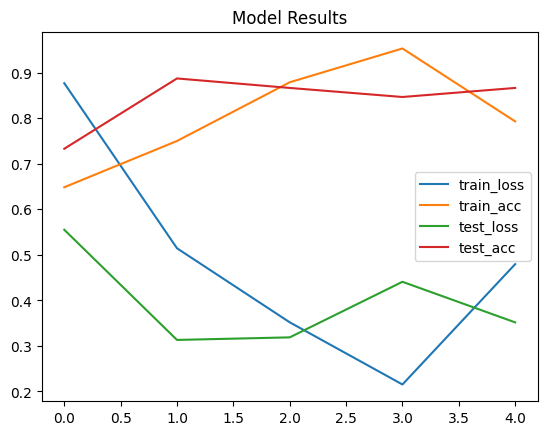

In [61]:
import pandas as pd

model_df = pd.DataFrame(results)
model_df.plot()
plt.title("Model Results")

In [66]:
model.__module__ = "custom_efficientnet_b0_model"
model.__module__

'custom_efficientnet_b0_model'

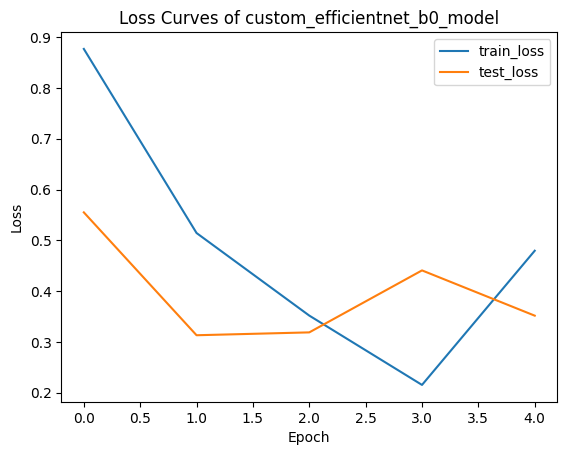

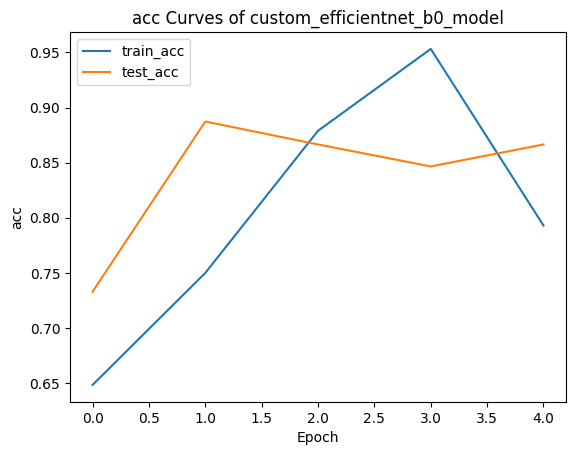

In [67]:
model_df[['train_loss','test_loss']].plot()
plt.title(f"Loss Curves of {model.__module__}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

model_df[['train_acc','test_acc']].plot()
plt.title(f"acc Curves of {model.__module__}")
plt.xlabel("Epoch")
plt.ylabel("acc")
plt.legend()

In [62]:
from typing import List, Tuple

from PIL import Image

# 1. Take in a trained model, class names, image path, image size, a transform and target device
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):


    # 2. Open image
    img = Image.open(image_path)

    # 3. Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    ### Predict on image ###

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
      # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
      transformed_image = image_transform(img).unsqueeze(dim=0)

      # 7. Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = model(transformed_image.to(device))

    # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 10. Plot image with predicted label and probability
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);

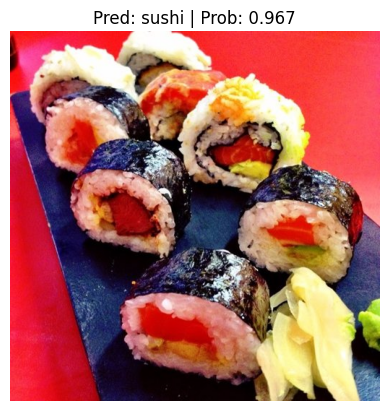

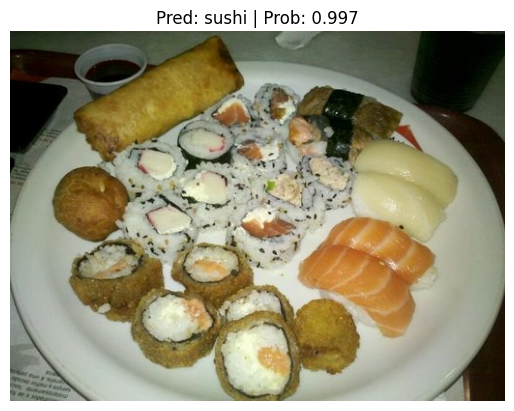

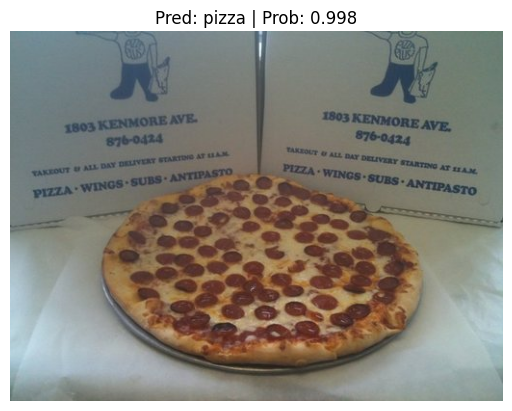

In [68]:
# Get a random list of image paths from test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg")) # get list all image paths from test data
test_image_path_sample = random.sample(population=test_image_path_list, # go through all of the test image paths
                                       k=num_images_to_plot) # randomly select 'k' image paths to pred and plot

# Make predictions on and plot the images
for image_path in test_image_path_sample:
    pred_and_plot_image(model=model,
                        image_path=image_path,
                        class_names=train_data.classes,
                        transform=weights.transforms(),
                        image_size=(224, 224))